# Decision Trees

Tree-based methods employ a segmentation strategy that partitions the feature / predictor space into a series of decisions which has the added benefit of being easy to understand. Think of it as a flow chart for making decisions. The viewer of the chart is presented with a diagram that offers outcomes in response to (yes / no) questions (decisions) about important predictors found in the data set. The advantages of tree-based methods include:

   - The model is generally easy to interpret 
   - The path to a decision is plainly spelled out (assuming that the number of tree splits is easy enough to trace).
   - The method can handle numeric and categorical
   - One does not generally need to pre process or normalize data - Missing data is less of a big deal

Disadvantages include:

   - Large trees are hard to follow - variance can be high
   - Trees can be overly complex
   - Overfitting can be a problem



## A Classification Example

Let’s use the Pima Indians data set as it relates to predicting whether someone has diabetes. This data is provided by the mlbench package. The relevant variables are:

    pregnant - Number of times pregnant
    glucose  - Plasma glucose concentration (glucose tolerance test)
    pressure - Diastolic blood pressure (mm Hg)
    triceps  - Triceps skin fold thickness (mm)
    insulin  - 2-Hour serum insulin (mu U/ml)
    mass       - Body mass index (weight in kg/(height in m)\^2)
    pedigree - Diabetes pedigree function
    age      - Age (years)
    diabetes - Class variable (test for diabetes)



In [1]:
# Read in the Data
import pandas as pd
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/pima.csv"
pm = pd.read_csv(url, sep=',')

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import KFold

X = pm.drop('diabetes',axis=1)
y = pm.diabetes

lb = preprocessing.LabelBinarizer(neg_label=0, pos_label=1)
y  = lb.fit(y).transform(y)

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

dtf = DecisionTreeClassifier(max_depth = 2)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 
  
# scoring data  
print(classification_report(y_test,dtf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       122
           1       0.79      0.31      0.45        70

    accuracy                           0.72       192
   macro avg       0.75      0.63      0.63       192
weighted avg       0.74      0.72      0.68       192



So one thing you should notice about a single tree is that it is easy to generate and, if the specified depth isn't too deep, easy to visualize. Let's plot the tree we just created.

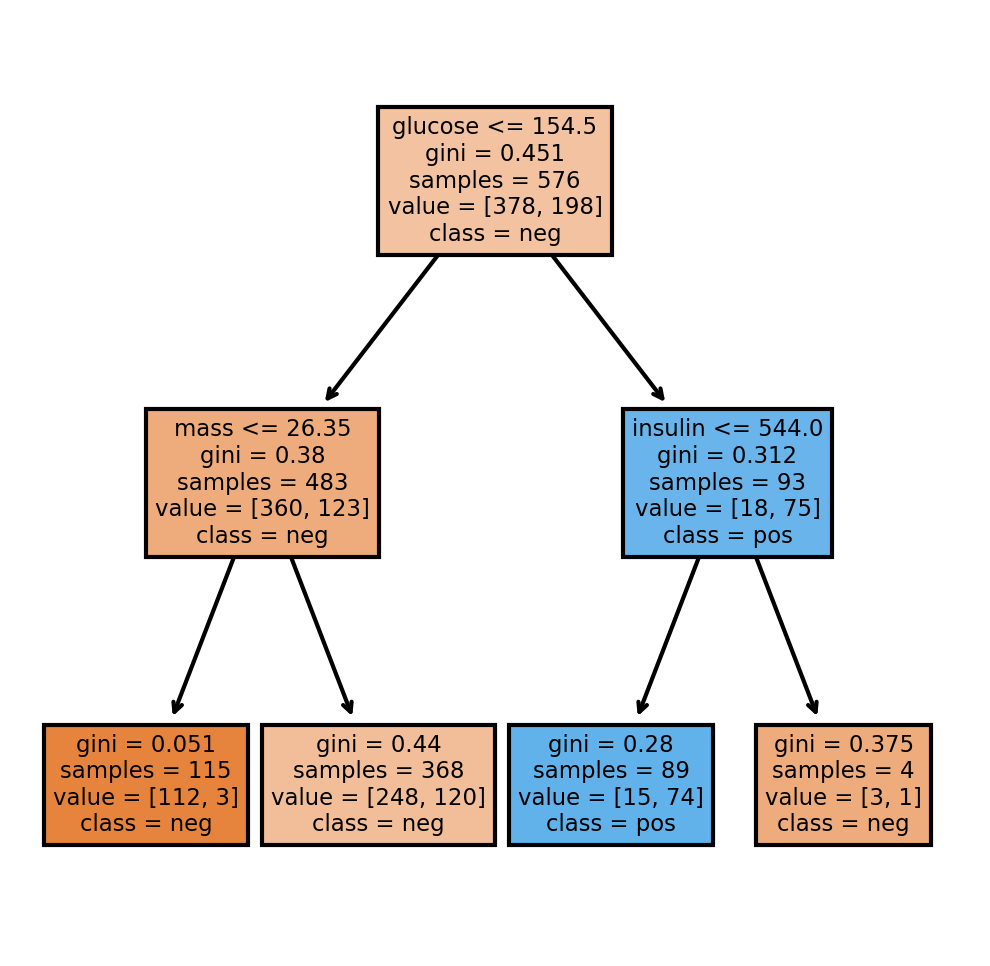

In [3]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
myp = tree.plot_tree(dtf,feature_names = X.columns, 
               class_names=(['neg','pos']),
               filled = True)

In [4]:
print(tree.export_text(dtf))

|--- feature_1 <= 154.50
|   |--- feature_5 <= 26.35
|   |   |--- class: 0
|   |--- feature_5 >  26.35
|   |   |--- class: 0
|--- feature_1 >  154.50
|   |--- feature_4 <= 544.00
|   |   |--- class: 1
|   |--- feature_4 >  544.00
|   |   |--- class: 0



That’s pretty understandable and you could show this to someone and they would probably get it without too much explanation as long as they had an awareness of the features in the data set. The “node” at the top is called the “root node” and the lines are “branches” that go either to a “terminal node” or to “leaf nodes” which involve some comparison. 

It’s a flow chart for decisions about whether someone has diabetes or not. Note that there is also information about what percentages of “pos” or “neg” there are in each branch. You might notice that I've limited the **depth** of the trees in large part to make the resulting tree easy to view. We could look at trees of greater depth which might (or not) offer a better model. Here we will set max_depth at 10 which will result in something much less readable. 

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       122
           1       0.66      0.56      0.60        70

    accuracy                           0.73       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.73      0.73       192



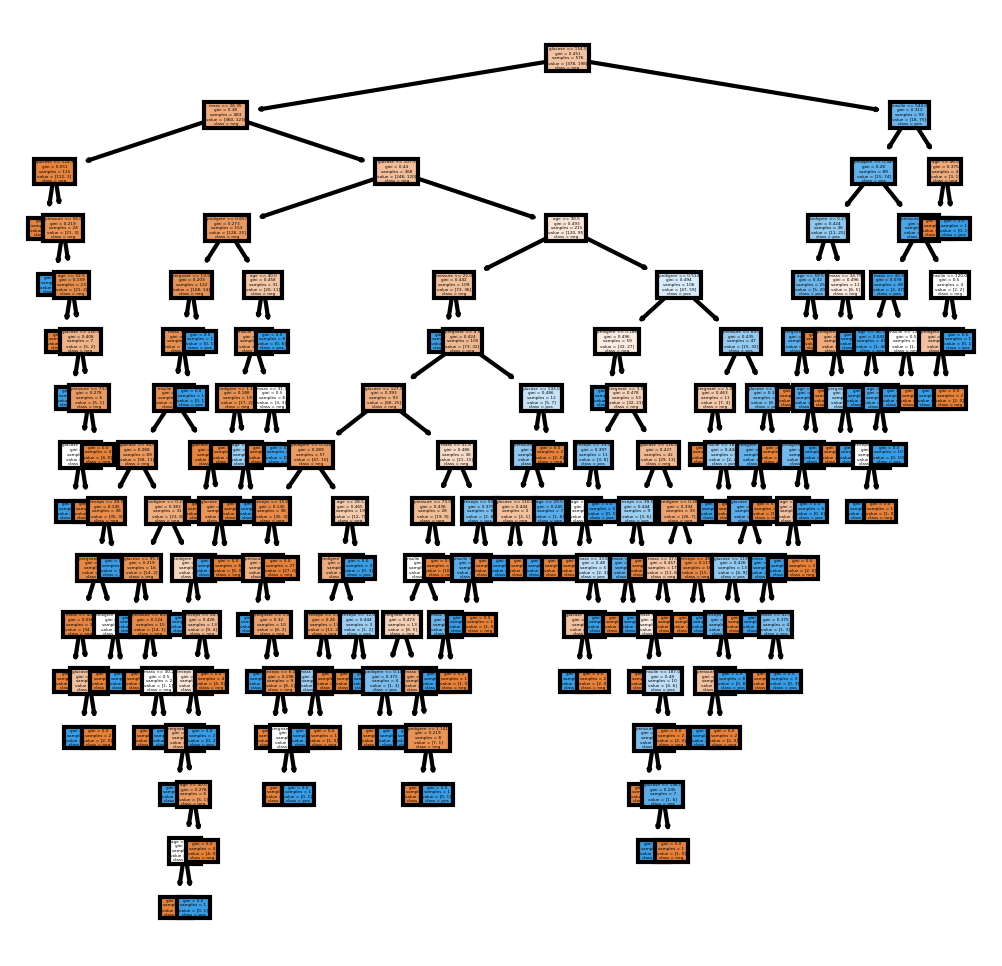

In [5]:
dtf = DecisionTreeClassifier(max_depth=20)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 
  
# scoring data  
print(classification_report(y_test,dtf.predict(X_test)))

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
myp = tree.plot_tree(dtf,feature_names = X.columns, 
               class_names=(['neg','pos']),
               filled = True)
plt.show()

### Feature Importance

One of the cool things about Decision Trees is that the object returns information relating to what it thinks represents the more important features. This is useful for determining what variables might be the most influential in explaining the relationship to an outcome variable. Many times, analysts will use a Decision Tree to help figure this out BEFORE using a more specific method. Check out how to view the information:

Feature Importance:  [0.06949678 0.33684126 0.0748634  0.07502985 0.054833   0.15217783
 0.12997891 0.10677897]


<AxesSubplot:>

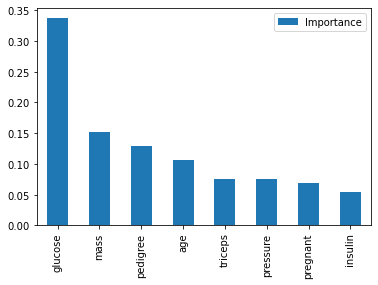

In [6]:
print("Feature Importance: ",dtf.feature_importances_)
feat_importances = pd.DataFrame(dtf.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

The reason this might be useful is that we can use fewer variables to build a model that might be as good at prediction as one which uses all variables. How does the following model compare with the one above which uses all variables ? 

In [7]:
X_small = X[['glucose','mass','age','pedigree']]
# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X_small, y, test_size = 0.25) 

dtf = DecisionTreeClassifier(max_depth = 2)

# fitting the data in the pipe 
dtf.fit(X_train, y_train) 

# scoring data  
print(classification_report(y_test,dtf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.75      0.93      0.83       123
           1       0.79      0.43      0.56        69

    accuracy                           0.76       192
   macro avg       0.77      0.68      0.70       192
weighted avg       0.76      0.76      0.73       192



And of course, you can build a series of trees using cross validation although we will soon discover that there are better ways to do this. 

In [8]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn import tree

scoring = {'prec': 'precision','roc_auc': 'roc_auc',
           'accuracy':'accuracy','recall':'recall'}

dtf = DecisionTreeClassifier()

# Cross Validate is similar to cross_val_score but allows for more than one scoring metric
cv_results = cross_validate(dtf, 
                            X_train, y_train, cv=5, scoring=scoring)
# Convert dict to dataframe
cv_df = pd.DataFrame.from_dict(cv_results)
print(cv_df)

   fit_time  score_time  test_prec  test_roc_auc  test_accuracy  test_recall
0  0.005445    0.006077   0.578947      0.669737       0.706897     0.550000
1  0.003620    0.005580   0.574468      0.704167       0.713043     0.675000
2  0.003189    0.006900   0.448276      0.555833       0.626087     0.325000
3  0.003862    0.005464   0.476190      0.603333       0.634783     0.500000
4  0.003077    0.006231   0.564103      0.670209       0.704348     0.564103


,test_prec,test_roc_auc,test_accuracy,test_recall
count,5.000000,5.000000,5.000000,5.000000
mean,0.528397,0.640656,0.677031,0.522821
std,0.061436,0.059876,0.042765,0.127726
min,0.448276,0.555833,0.626087,0.325000
25%,0.476190,0.603333,0.634783,0.500000
50%,0.564103,0.669737,0.704348,0.550000
75%,0.574468,0.670209,0.706897,0.564103
max,0.578947,0.704167,0.713043,0.675000


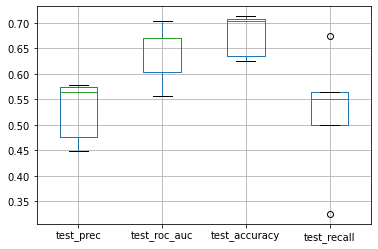

In [9]:
cv_df.boxplot(column=['test_prec','test_roc_auc','test_accuracy','test_recall'])

# Get summary stats
cv_df.iloc[:,2:6].describe()

## Tree Splitting

The resulting tree can be thought of as an upside down tree with the root at the top. The “trunk” proceeds downward and splits into subsets based on some decision (hence the word “decision” in the title). When classifying data the idea is to segment or partition data into groups/regions where each group contains or represents a single class (“yes/no”, “positive/negative”).

These groups or regions would represent a “pure” region. This is not always possible so a best effort is made. These regions are separated by decision boundaries which are used to make decisions. We’ll plot some example data to illustrate the case.

<img src="pics/cool_data.png" width ="600" height=600>

<img src="pics/cdc.png" width ="600" height=600>

<img src="pics/cdci.png" width ="600" height=600>

## Gini Index

We could begin to experiment with building more than one trees and adjusting one or more **hyperparameters** of a tree to see if it makes a difference. For example, we could use a different information criterion we build to see if and to what extent if impacts the result accuracy or whatever peformance measure we selected. The criterion argument allows us to specify the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. This brings up the whole issue of tuning hyperparameters which is something we will soon explore. 

<AxesSubplot:title={'center':'test_score'}, xlabel='criteria'>

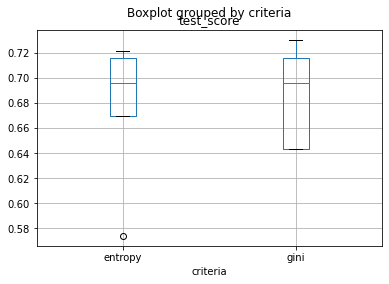

In [10]:
models = dict()
criteria = ['gini','entropy']

for criterion in criteria:
    dtf = DecisionTreeClassifier(criterion=criterion)
    models[criterion] = pd.DataFrame.from_dict(cross_validate(dtf, 
                                                              X_train, 
                                                              y_train, 
                                                              cv=5, 
                                                              scoring='accuracy'))
    models[criterion]['criteria'] = criterion
    
score_df = pd.concat(models.values(), ignore_index=True)
score_df.boxplot('test_score',by='criteria')

## Bagged Trees

Now we look at bagged trees which involves looking at many trees in aggregate - this is an ensemble method. It helps to reduce the variance associated with a single decision tree which can be highly sensitive to changes in data. The term bagging refers to “bootstrap aggregation”. 

The bootstrap method of sampling will resample the training data some number of times (with replacement) and retrain a number of models on the resampled data to average out the error. This looks something like:

1) The input data set is resampled with replacement some number of times (e.g. 10,50, 100)

2) The resampled data is usually a subset of the data which leaves some portion of the 
   data available to use a mini test set for prediction (“out of bag data”")

3) Get the prediction and evaluate it according to some measure (e.g. sensitivity, AUC)

4) Average out the performance measure from number 3

In [11]:
from sklearn.ensemble import BaggingClassifier

# Build a Bagging Classifier
model = BaggingClassifier()

model.fit(X_train, y_train.ravel())
y_test_preds = model.predict(X_test)

print("Number of estimators:",model.n_estimators)
print(classification_report(y_test,y_test_preds))
#print(recall_score(y_test,y_test_preds))


Number of estimators: 10
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       123
           1       0.65      0.54      0.59        69

    accuracy                           0.73       192
   macro avg       0.71      0.69      0.69       192
weighted avg       0.72      0.73      0.72       192



In [12]:
from sklearn.metrics import recall_score, accuracy_score

# Build a Bagging Classifier

trees = [100,250,500,750,1000,1500,2000]

for tree in trees:
    model = BaggingClassifier(n_estimators=tree)
    model.fit(X_train, y_train.ravel())
    y_test_preds = model.predict(X_test)
    print("Number of estimators:",model.n_estimators)
    print(round(accuracy_score(y_test,y_test_preds),3))

Number of estimators: 100
0.745
Number of estimators: 250
0.745
Number of estimators: 500
0.729
Number of estimators: 750
0.734
Number of estimators: 1000
0.745
Number of estimators: 1500
0.729
Number of estimators: 2000
0.734


The advantage of using bagged trees over a single tree is that you can generate a numberof trees to offset the potentially high variance observed in a single tree. Not only are you benefitting from multiple trees, you are also using bootstrap sampling along the way. 

### Random Forests

One of the extensions to bagged trees involves using Random Forests. In bagging, all features are used when considering if and when to split. However, with the Random Forest approach, a subset of features are selected at random at each split in a decision tree. You could think of random forests as being an extension of Bagged Trees. Typically they are also an improvement. 

As with other tree methods, we don’t have to worry a lot about preprocessing the data although we could if we wanted to. Basically, one of the main advantages of tree methods is that it tolerates a combination of data types on different scales which makes it good as a “go to” method for beginners.

Random forests will sample some number of features when considering a split. This can be influenced by a hyperparameter called mtry which is limited to the number of features in the data set.



   fit_time  score_time  test_prec  test_roc_auc  test_accuracy  test_recall
0  1.374405    0.161453   0.594595      0.830592       0.715517     0.550000
1  1.326696    0.165089   0.609756      0.834667       0.730435     0.625000
2  1.337139    0.162959   0.588235      0.785667       0.704348     0.500000
3  1.335196    0.215069   0.676471      0.810333       0.756522     0.575000
4  1.349310    0.165406   0.605263      0.798583       0.730435     0.589744


,test_prec,test_roc_auc,test_accuracy,test_recall
count,5.000000,5.000000,5.000000,5.000000
mean,0.614864,0.811968,0.727451,0.567949
std,0.035474,0.020831,0.019616,0.046687
min,0.588235,0.785667,0.704348,0.500000
25%,0.594595,0.798583,0.715517,0.550000
50%,0.605263,0.810333,0.730435,0.575000
75%,0.609756,0.830592,0.730435,0.589744
max,0.676471,0.834667,0.756522,0.625000


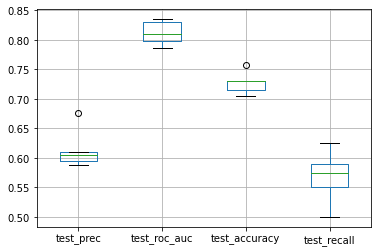

In [13]:
from sklearn.ensemble import RandomForestClassifier

scoring = {'prec': 'precision','roc_auc': 'roc_auc',
           'accuracy':'accuracy','recall':'recall'}

rf = RandomForestClassifier(n_estimators=1000,random_state=1)

# Cross validate
cv_results = cross_validate(rf, 
                            X_train, y_train.ravel(), 
                            cv=5, 
                            scoring=scoring)

# Convert dict to dataframe
cv_df = pd.DataFrame.from_dict(cv_results)
print(cv_df)

cv_df.boxplot(column=['test_prec','test_roc_auc','test_accuracy','test_recall'])

cv_df.iloc[:,2:6].describe()

We could use something like Repeated Kfold validation to see how performant our Regression trees perform over a series of repeated folds. 

## Boosted Trees

We’ll finish off this section with a discussion on boosted trees which represents an extension to random forests. Here is how we have been progressing thus far:

    Single Decision Tree
    Bagged Decision Trees (Aggregated Trees using all features)
    Random Forests (Many Trees using a number of of sampled features)

Methods 2 and 3 will use bootstrap sampling on the input data which means there will be sampling with replacement to generate a training set. After a tree is built then it will be applied to the OOB (Out Of Band) data left over from the bootstrap sample. This will then be used in the computation of an average.

With boosting, we don’t try to keep up with the idea of reducing the variance emerging from a number of individual trees (aka “learners”). Nor do we consider each tree as being independent and later try to integrate it into an average tree. With boosting we create a sequence of trees such that any subsequent tree represents an improvement on the previous tree(s) thus there is some dependency in the interest of improvement.

The process attempts to learn from previous “mistakes” in the creation of down stream trees. Boosting looks at the residuals from a tree and pays attention to any problematic observations when creating a subsequent tree. Here is an example. We’ll need to do a bit more prep on the data though prior to use:

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np

# Instantiate the Booster
gbc = GradientBoostingClassifier()
cv  = RepeatedKFold(n_splits=8, n_repeats=4, random_state=1)

# Get the scores
n_scores = cross_val_score(model, 
                           X, y, 
                           scoring = 'accuracy', 
                           cv=cv, n_jobs=-1, 
                           error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.767 (0.046)


## Trees For Regression

Predicting numeric outcomes can also be of interest. Given some patient characteristics relative to a disease, we might want to predict a viral load quantity. A gambler might want to predict a final score for a team. Unlike, classification problems, we are looking at estimating a numeric outcome. In addition to a Randon forest classification method, there is also one that permits Regression to predict a continuous outcome. We'll go back to our mtcars example and use Random Forests to predict the **mpg** variable. the cool think about using trees is that we do not have to worry about normalizing data (not that that is hard) or the mixture of quantitative and categorical data.

Since we are predicting a numeric outcome we would like to come up with a metric to help us figure out if the model we have is good or not. With classification situations we can employ confusion matrices and ROC curves. Here we will use something more simplistic but effective - Root Mean Square Error. The formula looks like the following where P represents a vector of predictions and O represents a vector of the observed (true) values.

$$RMSE = \sqrt\frac{\sum_i^n(P_i-O_i)^2}{n}$$

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

X = mtcars.drop('mpg',axis=1)
y = mtcars.mpg

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


forest = RandomForestRegressor()
forest.fit(X_train, y_train)
print("RMSE: ",mean_squared_error(y_test,forest.predict(X_test)))


RMSE:  7.361475571428578


In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"
mtcars = pd.read_csv(url)

X = mtcars.drop('mpg',axis=1)
y = mtcars.mpg

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

forest = RandomForestRegressor(900)
forest.fit(X_train, y_train)
print("RMSE: ",mean_squared_error(y_test,forest.predict(X_test)))

RMSE:  3.209166885361588


We could use something like Repeated Kfold validation to see how performant our Regression trees perform over a series of repeated folds. 

In [17]:
# We have to designate a scoring metric 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold

mse = make_scorer(mean_squared_error)

# Set up some folds
repeat_kfold = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)

forest = RandomForestRegressor(900)
# The cross_validate function handles the execution of the model
# as well as the management of the folds

cv  = cross_validate(forest,X,y,scoring=(mse), cv=repeat_kfold, return_train_score=True)

# Here we print out the rmse of the test / holdout data
print("Test RMSE per fold:",(cv['test_score']**0.5))

# Look at the mean of this RMSE array
print("Mean Test RMSE:",(cv['test_score']**0.5).mean().round(2))

# Look at the mean of this RMSE array
print("Mean Train RMSE:",(cv['train_score']**0.5).mean().round(2))

Test RMSE per fold: [4.56334375 2.30820403 1.12854949 2.95850432 2.16129538 2.05034689
 2.42816456 2.85687579 2.3712995 ]
Mean Test RMSE: 2.54
Mean Train RMSE: 0.92


## Parameters Vs HyperParameters

Model parameters are things that are generated as part of the modeling process. These might be things like slope and intercept from a linear model or, in the case of a Decision Tree, the number of splits in the final tree or the total number of leaves.

Hyper parameters (sometimes called metaparameters) represent information that is supplied in the form of an argument **prior** to the call to the method to generate results. These parameters might not be something one can intelligently set without some experimentation. Obviously, the more theoretical or background knowledge one has about a given method then the easier it becomes to establish "better" values for arguments than the defaults. 

Most modeling functions have default values for various arguments but this does not mean that the defaults are appropriate for all cases. You can always view the documentation for a given function such as the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Note that there are a number of parameters which could be set in conjunction with other parameters that might, or not, yield a more accurate or sensitive model. 

<img src="pics/skle.png" width ="700" height=700>

Earlier, we experimented with the "criteria" hyperparameter to see which one gave the best performance. This was a manual process and somewhat cumbersome especially when considering what we might do should we want to change other parameters in combination with the criteria.

<AxesSubplot:title={'center':'test_score'}, xlabel='criteria'>

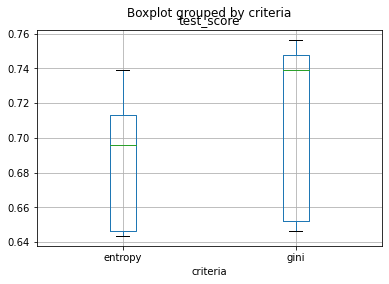

In [18]:
X = pm.drop('diabetes',axis=1)
y = pm.diabetes

lb = preprocessing.LabelBinarizer(neg_label=0, pos_label=1)
y  = lb.fit(y).transform(y)

# Splitting data into train and testing part 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 


models = dict()
criteria = ['gini','entropy']

for criterion in criteria:
    dtf = DecisionTreeClassifier(criterion=criterion)
    models[criterion] = pd.DataFrame.from_dict(cross_validate(dtf, 
                                                              X_train, 
                                                              y_train, 
                                                              cv=5, 
                                                              scoring='accuracy'))
    models[criterion]['criteria'] = criterion
    
score_df = pd.concat(models.values(), ignore_index=True)
score_df.boxplot('test_score',by='criteria')

In [19]:
dtf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'max_features': ["auto", "sqrt", "log2"]}

# decision tree model
dtree_model=DecisionTreeClassifier()

#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=8)

#fit model to data
dtree_gscv.fit(X_train, y_train)
    
dtree_gscv.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt'}

In [21]:

sorted(dtree_gscv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [22]:
grid_predictions = dtree_gscv.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       134
           1       0.57      0.71      0.63        58

    accuracy                           0.75       192
   macro avg       0.71      0.74      0.72       192
weighted avg       0.77      0.75      0.76       192



In [23]:
dtree_gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [24]:
pm

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,pos
1,1,85,66,29,0,26.6,0.351,31,neg
2,8,183,64,0,0,23.3,0.672,32,pos
3,1,89,66,23,94,28.1,0.167,21,neg
4,0,137,40,35,168,43.1,2.288,33,pos
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,neg
764,2,122,70,27,0,36.8,0.340,27,neg
765,5,121,72,23,112,26.2,0.245,30,neg
766,1,126,60,0,0,30.1,0.349,47,pos


In [25]:
from sklearn.feature_selection import SelectKBest, chi2
bestf = SelectKBest(score_func=chi2,k=8)
fit = bestf.fit(X,y)

In [26]:
fit.scores_

array([ 111.51969064, 1411.88704064,   17.60537322,   53.10803984,
       2175.56527292,  127.66934333,    5.39268155,  181.30368904])

In [28]:
from IPython.display import Image
Image(url='http://python.org/images/python-logo.gif')